<a href="https://colab.research.google.com/github/dhanushuUzumaki/100-days-of-code/blob/master/CNN_Project_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [21]:
import re

import os
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.python.keras.datasets import cifar10
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.util import deprecation
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras.layers import Activation, Conv2D, BatchNormalization
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import GlobalAveragePooling2D, Dense
import matplotlib.pyplot as plt
from keras.models import model_from_yaml

Using TensorFlow backend.


In [0]:
def disable_warnings():
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    deprecation._PRINT_DEPRECATION_WARNINGS = False


def flatten_layers(_layers):
    layers = []
    for x in _layers:
        try:
            for l in x:
                layers.append(l)
        except TypeError:
            layers.append(x)
    return layers


def parse(net):
    match = re.match(r'([a-z]*)(\d+)', net) # seperate string and number
    net_type, n_layers = match.group(1), match.group(2)
    residual = (net_type == 'resnet')
    n = (int(n_layers) - 2) // 6
    return n, residual

In [0]:
disable_warnings()

In [0]:
class ConvBNRelu(Sequential):
    def __init__(self, filters, kernel_size, strides, skip_relu=False, input_shape=None):
        conv2d_kwargs = {'input_shape': input_shape} if input_shape is not None else {}
        layers = [
            Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                   padding='same', kernel_regularizer=l2(1e-4), **conv2d_kwargs),
            BatchNormalization(),
        ]
        if not skip_relu:
            layers.append(Activation('relu'))
        super().__init__(layers)


class ResidualBlock(Model):
    def __init__(self, layers, activation):
        super().__init__()
        self._layers = layers
        self.activation = activation
        self._called = False

    def call(self, inputs, **kwargs):
        # so that we don't call twice        
        assert not self._called

        x = inputs
        for layer in self._layers:
            x = layer(x)
        if inputs.shape.as_list() != x.shape.as_list():
            inputs = self._reshape(inputs, x.shape.as_list())
        x = tf.add(inputs, x)
        x = Activation(self.activation)(x)

        self._called = True
        return x

    def _reshape(self, inputs, x_shape):
        # Downsample feature map by dropping pixels
        # Upsample channels using a learned transformation
        size_in, size_out = inputs.shape.as_list()[1], x_shape[1]
        downsample = size_in // size_out
        n_channels = x_shape[3]
        inputs = Conv2D(kernel_size=1, filters=n_channels, strides=downsample)(inputs)
        return inputs


class ConvBNReluResidualBlock(ResidualBlock):
    def __init__(self, filters, kernel_size, strides):
        layers = [
            ConvBNRelu(filters=filters, kernel_size=kernel_size, strides=strides),
            ConvBNRelu(filters=filters, kernel_size=kernel_size, strides=strides, skip_relu=False),
        ]
        super().__init__(layers, activation='relu')


class ConvBNReluBlock(Sequential):
    def __init__(self, filters, kernel_size, strides):
        layers = [
            ConvBNRelu(filters=filters, kernel_size=kernel_size, strides=strides),
            ConvBNRelu(filters=filters, kernel_size=kernel_size, strides=strides)
        ]
        super().__init__(layers)


In [0]:
def make_resnet(net):
    n, residual = parse(net)
    print("Net: detected n = {} {} shortcuts".format(n, 'with' if residual else 'without'))

    Block = ConvBNReluResidualBlock if residual else ConvBNReluBlock
    layers = [
        ConvBNRelu(strides=1, kernel_size=3, filters=16, input_shape=(32, 32, 3)),

        Block(strides=1, kernel_size=3, filters=16),
        [Block(strides=1, kernel_size=3, filters=16) for _ in range(n - 1)],

        Block(strides=2, kernel_size=3, filters=32),
        [Block(strides=1, kernel_size=3, filters=32) for _ in range(n - 1)],

        Block(strides=2, kernel_size=3, filters=64),
        [Block(strides=1, kernel_size=3, filters=64) for _ in range(n - 1)],

        GlobalAveragePooling2D(),
        Dense(10, 'softmax')
    ]
    layers = flatten_layers(layers)

    model = Sequential(layers)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model


In [0]:
def train_model(net="resnet20", epochs=50, batch_size=32):    
    model = make_resnet(net)
    model.summary()    
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs,
                        callbacks=[ReduceLROnPlateau(verbose=1, patience=20)]) #modelcheckpoint won't work for subclassed networks
    return history, model

In [0]:
def plot_training_curves(history):

    # training and validation data accuracy
    acc     = history.history['val_acc']
    val_acc = history.history['acc']

    # training and validation data loss
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    # plot accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    # plot loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


In [9]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train.astype('float32') / 255, x_test.astype('float32') / 255
mean = np.mean(x_train, axis=0)
x_train -= mean
x_test -= mean

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

170500096/170498071 [==============================] - 13s 0us/step


In [18]:
simpleNetworkHistory, simpleNetworkModel = train_model(net="20")

Net: detected n = 3 without shortcuts
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_bn_relu (ConvBNRelu)    (None, 32, 32, 16)        512       
_________________________________________________________________
conv_bn_relu_block (ConvBNRe (None, 32, 32, 16)        4768      
_________________________________________________________________
conv_bn_relu_block_1 (ConvBN (None, 32, 32, 16)        4768      
_________________________________________________________________
conv_bn_relu_block_2 (ConvBN (None, 32, 32, 16)        4768      
_________________________________________________________________
conv_bn_relu_block_3 (ConvBN (None, 8, 8, 32)          14144     
_________________________________________________________________
conv_bn_relu_block_4 (ConvBN (None, 8, 8, 32)          18752     
_________________________________________________________________
conv_bn_relu_block

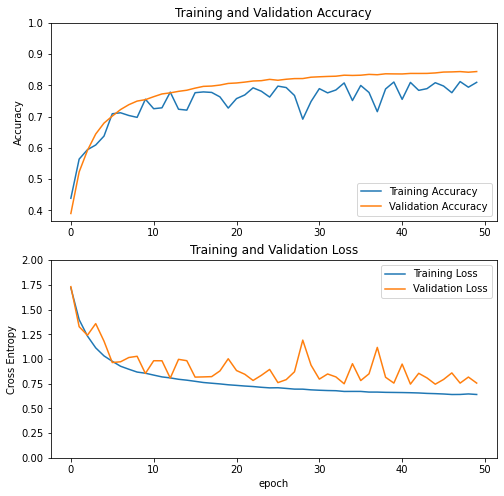

In [19]:
plot_training_curves(simpleNetworkHistory)

In [20]:
resnet20History, resnet20Model = train_model(net="resnet20")

Net: detected n = 3 with shortcuts
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_bn_relu_19 (ConvBNRelu) (None, 32, 32, 16)        512       
_________________________________________________________________
conv_bn_relu_residual_block  (None, 32, 32, 16)        4768      
_________________________________________________________________
conv_bn_relu_residual_block_ (None, 32, 32, 16)        4768      
_________________________________________________________________
conv_bn_relu_residual_block_ (None, 32, 32, 16)        4768      
_________________________________________________________________
conv_bn_relu_residual_block_ (None, 8, 8, 32)          14144     
_________________________________________________________________
conv_bn_relu_residual_block_ (None, 8, 8, 32)          18752     
_________________________________________________________________
conv_bn_relu_residu

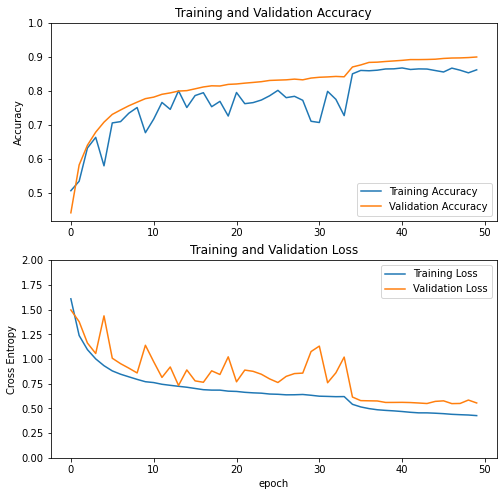

In [22]:
plot_training_curves(resnet20History)

In [0]:
!mkdir models

In [0]:
simpleNetworkModel.save_weights("./models/simpleNetworkModelWeights")

In [0]:
resnet20Model.save_weights("./models/resnet20ModelWeights")